In [30]:
import os
import numpy as np
import re

# sys.path.insert(1, '../../ProcessEvents')
from Convert_to_Profiles_Functions import *
from Get_Events_Functions import *
from Steef_Functions import *

In [40]:
def create_event_characteristics_dict(this_event):
    
    max_quintile_molly=find_max_quintile(this_event['precipitation (mm)'],5)
    max_third_molly=find_max_quintile(this_event['precipitation (mm)'],3)
    max_quintile_steef=analyse_event(this_event['precipitation (mm)'])[0]
    duration = len(this_event) / 2
    DurationRange_personalised_allems = find_dur_category([1.5, 5.0, 11.5, 22.5, 166.5], ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    DurationRange_notpersonalised = find_dur_category([0.25, 2.10, 6.45, 19.25, 1000], 
                                                      ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    return {
        "season" : get_season(this_event['times'][0]),
        'duration':duration,
        "DurationRange_personalised_allems": DurationRange_personalised_allems,
        'DurationRange_notpersonalised':DurationRange_notpersonalised,
        "year":extract_year(this_event),
        "month":get_month(this_event),
        'Volume': sum(this_event['precipitation (mm)'].values),
        'max_intensity': this_event['precipitation (mm)'].max() *2,
        "max_quintile_molly":max_quintile_molly,
        "max_third_molly": max_third_molly,
        'max_quintile_steef' :max_quintile_steef,
        'Loading_profile_molly' :quintile_mapping[max_quintile_molly],
        'Loading_profile_third_molly':quintile_mapping_thirds[max_third_molly],
        'Loading_profile_steef':quintile_mapping[max_quintile_steef],
        'D50_index': calculate_D50(this_event['precipitation (mm)'])[1]
    }

def find_max_quintile (precip, n):
    # Difference with this to Huff curve function, is it doesnt normalise
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
    return max_quintile_profile 

def find_dur_category (bin_edges, duration_labels, duration):
    # Create a pandas Series with the duration
    # Use pd.cut to assign the duration to a bin
    binned_duration = pd.cut(pd.Series([duration]), bins=bin_edges, labels=duration_labels, right=True,  include_lowest=True)
    return binned_duration.iloc[0]

def get_month (df):
    # Step 2: Calculate the median (middle value)
    median_time = df['times'].median()

    # Step 3: Extract the month from the median value
    median_month = median_time.month

    # Convert month number to month name (optional)
    month_name = median_time.strftime('%B')

    return median_month

def calculate_D50(precipitation_values):
    """
    Calculate D50, the point in time when 50% of cumulative precipitation has occurred during an event.
    
    Parameters:
    - precipitation_values: A list or array of precipitation values for a given event.
    
    Returns:
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    """
    # Ensure input is a numpy array
    precipitation_values = np.array(precipitation_values)
    
    # Step 1: Calculate the cumulative precipitation
    cumulative_precip = np.cumsum(precipitation_values)
    
    # Step 2: Determine the total precipitation
    total_precip = cumulative_precip[-1]
    
    # Step 3: Find the index where 50% of the total precipitation is reached
    halfway_precip = total_precip / 2.0
    D50_index = np.where(cumulative_precip >= halfway_precip)[0][0]  # First index where cumulative precipitation >= 50%
    
    # Step 4: Calculate the percentage of the event duration (D50)
    total_timesteps = len(precipitation_values)
    D50 = (D50_index / (total_timesteps - 1)) * 100

    return D50, D50_index, cumulative_precip

def create_profiles_dict(this_event):
    dimensionless_cumulative_rainfall, dimensionless_cumulative_times = create_huff_curves(this_event['precipitation (mm)'])
    interpolated_cumulative_rainfall, interpolated_times = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
    irain_14vals, irain_times_14vals = create_irain_profile(interpolated_cumulative_rainfall, True)
    irain, irain_times = create_irain_profile(interpolated_cumulative_rainfall, False)
    return {
        "dimensionless_cumulative_rainfall" : dimensionless_cumulative_rainfall,
        'dimensionless_cumulative_times':dimensionless_cumulative_times,
        "interpolated_cumulative_rainfall": interpolated_cumulative_rainfall,
        'interpolated_times':interpolated_times,
        "irain_14vals":irain_14vals,
        'irain_times_14vals': irain_times_14vals,
        "irain":irain,
        "irain_times": irain_times} 

def get_dur_for_which_this_is_amax(file):
    match = re.search(r'(\d+(\.\d+)?)hrs', file)

    # Extract and print the result if a match is found
    if match:
        extracted_value = match.group(1)
        return extracted_value
    
def adjust_feb_dates(datetime_str):
    try:
        # Split the string into date and time parts (assuming standard format)
        date_part, time_part = datetime_str.split(' ')
        year, month, day = map(int, date_part.split('-'))
        
        # Check if it's February and the day is invalid (29th or 30th)
        if month == 2 and day in [29, 30]:
            # Return the date as February 28th, keeping the time part intact
            return f'{year}-02-28 {time_part}'
        
        # Return the original datetime string if valid
        return datetime_str
    except:
        # In case of unexpected formats or errors, return the original string
        return datetime_str    

In [250]:
def plot_polar_months_plot(months_df, ax, title, rmax, name_variable_to_plot):
    
    N = 12
    width = (2*np.pi) / N
    bottom = 8
    
    # Define bins and their positions
    circular_bins = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    circular_bins = np.append(circular_bins, 2 * np.pi)
    circular_plot_position = circular_bins + 0.5*np.diff(circular_bins)[0]
    circular_plot_position = circular_plot_position[:-1]
    circular_plot_position = circular_plot_position + 0.5*np.pi
    
    # Count numbers in each month
    count = months_df['month'].value_counts().sort_index()
    count = count.reindex(list(range(count.index.min(),count.index.max()+1)),fill_value=0)
    
    # Calculate percentage
    total_events = count.sum()
    percentage = (count / total_events) * 100  # Calculate percentage for each month
    
    if name_variable_to_plot == 'Percentage':
        variable_to_plot = percentage
    elif name_variable_to_plot == 'Count':
        variable_to_plot = count
    
    # Define colors for each month
    colors = [
              '#0033cc',  # Jan (Light Blue)
              '#0033cc',  # Feb (Very Light Blue)
              '#ffcc00',  # Mar (Purple)
              '#ffcc00',  # Apr (Medium Purple)
              '#ffcc00',  # May (Bright Yellow)
              '#ff8c00',  # Jun (Red-Orange)
              '#ff8c00',  # Jul (Tomato Red)
              '#ff8c00',  # Aug (Dark Orange)
              '#8b4513',  # Sep (Saddle Brown)
              '#8b4513',  # Oct (Orange)
              '#8b4513',# Nov (Dark Goldenrod)
              '#0033cc',  # Dec (Dark Blue)
    ]  
    colors.reverse()
    
    # Plot
    ax.bar(circular_plot_position, variable_to_plot.iloc[::-1], width=width, color=colors)
    

    # Format
    ax.set_title(title, fontsize=20, pad=50)
    ax.set_rlabel_position(90)
    ax.xaxis.grid(False)
    if  name_variable_to_plot == 'Percentage':
        ax.set_ylim(0, 20)
    ax.set_xticks(circular_plot_position - 0.5*np.pi)
    ax.set_xticklabels(['Mar', 'Feb', 'Jan',
                         'Dec', 'Nov', 'Oct',
                        'Sep', 'Aug', 'Jul',
                        'Jun', 'May', 'Apr'])
    
    
def plot_polar_months_plot_overlay(months_df_present, months_df_future, ax, title):
    N = 12
    width = (2 * np.pi) / N
    
    # Define bins and their positions
    circular_bins = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    circular_bins = np.append(circular_bins, 2 * np.pi)
    circular_plot_position = circular_bins + 0.5 * np.diff(circular_bins)[0]
    circular_plot_position = circular_plot_position[:-1]
    circular_plot_position = circular_plot_position + 0.5 * np.pi
    
    # Count numbers in each month for present and future datasets
    count_present = months_df_present['month'].value_counts().sort_index()
    count_present = count_present.reindex(list(range(count_present.index.min(), count_present.index.max() + 1)), fill_value=0)
    total_present = count_present.sum()
    percentage_present = (count_present / total_present) * 100
    
    count_future = months_df_future['month'].value_counts().sort_index()
    count_future = count_future.reindex(list(range(count_future.index.min(), count_future.index.max() + 1)), fill_value=0)
    total_future = count_future.sum()
    percentage_future = (count_future / total_future) * 100
    
    # Define colors for each dataset
    colors_present = '#ffcc00'  # Yellow for present
    colors_future = '#0033cc'    # Blue for future

    # Plot percentage for present and future datasets
    ax.bar(circular_plot_position, percentage_present.iloc[::-1], width=width, color=colors_present, alpha=0.5, label='Present')
    ax.bar(circular_plot_position, percentage_future.iloc[::-1], width=width, color=colors_future, alpha=0.5, label='Future')

    # Format
    ax.set_title(title, fontsize=20, pad=50)
    ax.set_rlabel_position(90)
    ax.xaxis.grid(False)
    ax.set_ylim(0, 20)  # Set limit based on percentage (0 to 100)
    ax.set_xticks(circular_plot_position - 0.5 * np.pi)
    ax.set_xticklabels(['Mar', 'Feb', 'Jan',
                        'Dec', 'Nov', 'Oct',
                        'Sep', 'Aug', 'Jul',
                        'Jun', 'May', 'Apr'])
    
    # Add legend
    ax.legend(loc='upper right')
    

In [8]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [36]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}

In [ ]:
def process_events(time_period, ems):
    events_dict = {}
    event_props_dict = {}
    event_profiles_dict = {}

    for em in ems:
        print(em)
        for gauge_num in range(0, 1293):
            if gauge_num not in [444, 827, 888]:
                if gauge_num % 100 == 0:
                    print(f"Processing gauge {gauge_num}")
                    indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/"

                    files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
                    files = np.sort(files)

                    for event_num, file in enumerate(files):
                        fp = indy_events_fp + f"{file}"
                        if '2080' in fp:
                            continue
                        
                        # Get event
                        this_event = read_event(gauge_num, fp)

                        # Get times and precipitation values
                        event_times = this_event['times']
                        event_precip = this_event['precipitation (mm)']

                        # Apply the function to adjust the dates in the 'times' column
                        event_times_fixed = event_times.apply(adjust_feb_dates)

                        # Create the DataFrame with corrected times
                        event_df = pd.DataFrame({'precipitation (mm)': event_precip, 'times': event_times_fixed})

                        # Create characteristics dictionary
                        event_props = create_event_characteristics_dict(event_df)

                        # Add the duration
                        event_props['dur_for_which_this_is_amax'] = get_dur_for_which_this_is_amax(fp)
                        # Add gauge number and ensemble member
                        event_props['gauge_num'] = gauge_num
                        event_props['em'] = em
                        event_props['filename'] = file

                        event_profiles = create_profiles_dict(event_df)

                        events_dict[f"{em}, {gauge_num}, {event_num}"] = event_df
                        event_props_dict[f"{em}, {gauge_num}, {event_num}"] = event_props
                        event_profiles_dict[f"{em}, {gauge_num}, {event_num}"] = event_profiles

    return events_dict, event_props_dict, event_profiles_dict

# Now you can call the function for both time periods
events_dict_present, event_props_dict_present, event_profiles_dict_present = process_events('Present',
                                                                                           ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc012', 'bc013', 'bc015', 'bc016', 'bc017', 'bc018'])

events_dict_future, event_props_dict_future, event_profiles_dict_future = process_events('Future', 
                                                                                        ['bb189','bb192', 'bb195', 'bb198', 'bb201', 'bb204','bb208' ,'bb211','bb216', 'bb219','bb222','bb225'])


In [ ]:
def process_events(time_period, valid_durations=None):
    events_dict = {}
    event_props_dict = {}
    event_profiles_dict = {}

    for em in ['bc005']:
        print(em)
        for gauge_num in range(0, 1293):
            if gauge_num not in [444, 827, 888]:
                if gauge_num % 100 == 0:
                    print(f"Processing gauge {gauge_num}")
                    indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/EventSet/"

                    files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
                    files = np.sort(files)

                    for event_num, file in enumerate(files):
                        fp = indy_events_fp + f"{file}"
                        if '2080' in fp:
                            continue
                        
                        # Get event
                        this_event = read_event(gauge_num, fp)

                        # Get times and precipitation values
                        event_times = this_event['times']
                        event_precip = this_event['precipitation (mm)']

                        # Apply the function to adjust the dates in the 'times' column
                        event_times_fixed = event_times.apply(adjust_feb_dates)

                        # Create the DataFrame with corrected times
                        event_df = pd.DataFrame({'precipitation (mm)': event_precip, 'times': event_times_fixed})

                        # Create characteristics dictionary
                        event_props = create_event_characteristics_dict(event_df)

                        # Add the duration
                        duration = get_dur_for_which_this_is_amax(fp)
                        event_props['dur_for_which_this_is_amax'] = duration
                        # Add gauge number and ensemble member
                        event_props['gauge_num'] = gauge_num
                        event_props['em'] = em
                        event_props['filename'] = file

                        # Check if the duration is in the valid_durations list, if provided
                        if valid_durations is None or duration in valid_durations:
                            event_profiles = create_profiles_dict(event_df)

                            events_dict[f"{em}, {gauge_num}, {event_num}"] = event_df
                            event_props_dict[f"{em}, {gauge_num}, {event_num}"] = event_props
                            event_profiles_dict[f"{em}, {gauge_num}, {event_num}"] = event_profiles

    return events_dict, event_props_dict, event_profiles_dict

# List of desired durations
valid_durations = [0.5, 1, 2, 3, 6, 12, 24]

# Process events for both time periods
results_present = {}
results_future = {}

for duration in valid_durations:
    print(f"Processing duration: {duration}h")
    
    # Create filtered results for the Present
    events_dict_present, event_props_dict_present, event_profiles_dict_present = process_events('Present', valid_durations=[duration])
    results_present[duration] = {
        'events': events_dict_present,
        'props': event_props_dict_present,
        'profiles': event_profiles_dict_present
    }
    
#     # Create filtered results for the Future
#     events_dict_future, event_props_dict_future, event_profiles_dict_future = process_events('Future', valid_durations=[duration])
#     results_future[duration] = {
#         'events': events_dict_future,
#         'props': event_props_dict_future,
#         'profiles': event_profiles_dict_future
#     }


Processing duration: 0.5h
bc005
Processing gauge 0
Processing gauge 100


{}

In [166]:
months_present = [event['month'] for event in event_props_dict_present.values()]
months_df_present = pd.DataFrame({'month':months_present})
len(months_df_present)

14834

In [165]:
months_future = [event['month'] for event in event_props_dict_future.values()]
months_df_future = pd.DataFrame({'month':months_future})
len(months_df_future)

13715

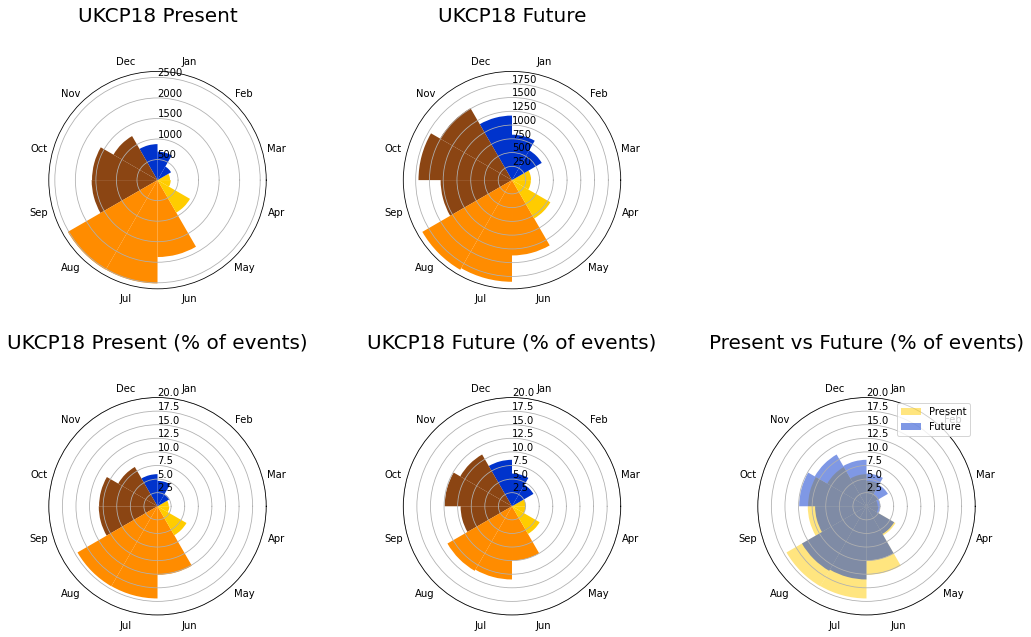

In [252]:
max_present = months_df_present['month'].value_counts().max()
max_future = months_df_future['month'].value_counts().max()
rmax = max(max_present, max_future) + 500  # Adjust to leave space above bars    
    
fig = plt.figure(figsize=(18, 10))
fig.subplots_adjust(hspace=0.5)
ax1 = plt.subplot(231, polar=True)
ax2 = plt.subplot(232, polar=True)
plot_polar_months_plot(months_df_present, ax1, "UKCP18 Present", rmax, name_variable_to_plot = 'Count')
plot_polar_months_plot(months_df_future, ax2,"UKCP18 Future", rmax, name_variable_to_plot = 'Count')

ax3 = plt.subplot(234, polar=True)
ax4 = plt.subplot(235, polar=True)
ax5 = plt.subplot(236, polar=True)
plot_polar_months_plot(months_df_present, ax3, "UKCP18 Present (% of events)", rmax, name_variable_to_plot = 'Percentage')
plot_polar_months_plot(months_df_future, ax4,"UKCP18 Future (% of events)", rmax, name_variable_to_plot = 'Percentage')
plot_polar_months_plot_overlay(months_df_present, months_df_future, ax5, "Present vs Future (% of events)")